# Lab Vision Sytems: Session 2

# Today: 
### 1: Autograd
### 2: Linear and Logistic Regression with PyTorch
### 3: Training and Evaluation Loops

Autograd: Automatic Differentiation
===================================

Central to all neural networks in PyTorch is the ``autograd`` package.
Let’s first briefly visit this, and we will then go to training our
first neural network.


The ``autograd`` package provides automatic differentiation for all operations
on Tensors. It is a define-by-run framework, which means that your backprop is
defined by how your code is run, and that every single iteration can be
different.

Let us see this in more simple terms with some examples.


## Tensor and Grad

``torch.Tensor`` is the central class of the package. If you set its attribute
``.requires_grad`` as ``True``, it starts to track all operations on it. When
you finish your computation you can call ``.backward()`` and have all the
gradients computed automatically. The gradient for this tensor will be
accumulated into ``.grad`` attribute.

To stop a tensor from tracking history, you can call ``.detach()`` to detach
it from the computation history, and to prevent future computation from being
tracked.

To prevent tracking history (and using memory), you can also wrap the code block
in ``with torch.no_grad():``. This can be particularly helpful when evaluating a
model because the model may have trainable parameters with
``requires_grad=True``, but for which we don't need the gradients.

There’s one more class which is very important for autograd
implementation - a ``Function``.

``Tensor`` and ``Function`` are interconnected and build up an acyclic
graph, that encodes a complete history of computation. Each tensor has
a ``.grad_fn`` attribute that references a ``Function`` that has created
the ``Tensor`` (except for Tensors created by the user - their
``grad_fn is None``).

If you want to compute the derivatives, you can call ``.backward()`` on
a ``Tensor``. If ``Tensor`` is a scalar (i.e. it holds a one element
data), you don’t need to specify any arguments to ``backward()``,
however if it has more elements, you need to specify a ``gradient``
argument that is a tensor of matching shape.



``.requires_grad_( ... )`` changes an existing Tensor's ``requires_grad``
flag in-place. The input flag defaults to ``False`` if not given.



In [1]:
import torch

In [2]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(f"'a' requires gradient?: {a.requires_grad}")
a.requires_grad_(True)
print(f"'a' requires gradient?: {a.requires_grad}")
b = (a * a).sum()
print(f"'b' grad function: {b.grad_fn}")

'a' requires gradient?: False
'a' requires gradient?: True
'b' grad function: <SumBackward0 object at 0x7f8f9050a340>


#### We dont need to specify requires_grad = False, since by default it flags it as False

In [3]:
tensor1 = torch.Tensor([[1, 2, 3], 
                       [4, 5, 6]])

print(tensor1)
print(tensor1.requires_grad)

tensor([[1., 2., 3.],
        [4., 5., 6.]])
False


In [4]:
tensor2 = torch.Tensor([[7, 8, 9], 
                        [10, 11, 12]])

print(tensor2)
print(tensor2.requires_grad)

tensor([[ 7.,  8.,  9.],
        [10., 11., 12.]])
False


#### The requires\_grad\_() function sets requires_grad to True

In [5]:
tensor1.requires_grad_()

tensor([[1., 2., 3.],
        [4., 5., 6.]], requires_grad=True)

In [6]:
tensor1.requires_grad

True

#### The .grad property stores all the gradients for the tensor
However, until we call the ``backward()`` there are no gradients computed yet

In [7]:
print(tensor1.grad)

None


#### The .grad_fn property contains the gradient function
This has not been set either

In [8]:
print(tensor1.grad_fn)

None


#### Create a new output tensor from our original tensor

In [9]:
output_tensor = tensor1 * tensor2

#### The requires_grad property has been derived from the original tensor

In [10]:
output_tensor.requires_grad

True

#### There are still no gradients

In [11]:
print(output_tensor.grad)

None


<ipython-input-11-bf53a7edc26d>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(output_tensor.grad)


#### But there is a gradient function
This is from the multiplication operation performed on the original tensor 

In [12]:
print(output_tensor.grad_fn)

#### The original tensor still does not have a gradient function

In [13]:
print(tensor1.grad_fn)

None


In [14]:
print(tensor2.grad_fn)

None


#### Changing the operation for the output changes the gradient function
The gradient function only contains the last operation. Here, even though there is a multiplication as well as a mean, only the mean calculation is recorded as the gradient function

In [15]:
output_tensor = (tensor1 * tensor2).mean()
print(output_tensor.grad_fn)

#### In spite of setting a gradient function for the output, the gradients for the input tensor is still empty

In [16]:
print(tensor1.grad)

None


#### To calculate the gradients, we need to explicitly perform a backward propagation

In [17]:
output_tensor.backward()

#### The gradients are now available for the input tensor

Future calls to backward will accumulate gradients into this vector

In [18]:
print(tensor1.grad)

tensor([[1.1667, 1.3333, 1.5000],
        [1.6667, 1.8333, 2.0000]])


#### The gradient vector is the same shape as the original vector

In [19]:
tensor1.grad.shape, tensor1.shape

(torch.Size([2, 3]), torch.Size([2, 3]))

## Enabling and Disabling Gradient Calculations 
You can also stops autograd from tracking history on newly created tensors with *requires_grad=True* by wrapping the code block in 
**with torch.no_grad()**

In [22]:
tensor1 = torch.Tensor([[1, 2, 3], 
                       [4, 5, 6]])
tensor1.requires_grad = True

In [23]:
with torch.no_grad():
    
    new_tensor = tensor1 * 3
    
    print('new_tensor = ', new_tensor)
    
    print('requires_grad for tensor1 = ', tensor1.requires_grad)
    
    print('requires_grad for new_tensor = ', new_tensor.requires_grad)

new_tensor =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
requires_grad for tensor1 =  True
requires_grad for new_tensor =  False


#### Can turn off gradient calculations performed within a function

In [24]:
def calculate(t):
    return t * 2

In [25]:
@torch.no_grad()
def calculate_with_no_grad(t):
    return t * 2

In [26]:
result_tensor = calculate(tensor1)

result_tensor

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]], grad_fn=<MulBackward0>)

In [27]:
result_tensor.requires_grad

True

In [28]:
result_tensor_no_grad = calculate_with_no_grad(tensor1)

result_tensor_no_grad

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]])

In [29]:
result_tensor_no_grad.requires_grad

False

#### Can explicitly enabled gradients within a no_grad() context

There is an equivalent **torch.enable_grad()**  as well

In [30]:
with torch.no_grad():
    
    new_tensor_no_grad = tensor1 * 3
    
    print('new_tensor_no_grad = ', new_tensor_no_grad)
    
    with torch.enable_grad():
        
        new_tensor_grad = tensor1 * 3
    
        print('new_tensor_grad = ', new_tensor_grad)

new_tensor_no_grad =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
new_tensor_grad =  tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]], grad_fn=<MulBackward0>)


### Result tensors get requires_grad properties from input tensors

In [31]:
tensor_one = torch.tensor([[1.0, 2.0], 
                           [3.0, 4.0]], requires_grad=True)  
tensor_one

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [32]:
tensor_two = torch.Tensor([[5, 6], 
                           [7, 8]])
tensor_two

tensor([[5., 6.],
        [7., 8.]])

#### enable the gradients for  two tensors

In [33]:
tensor_one.requires_grad

True

In [34]:
tensor_two.requires_grad_()

tensor([[5., 6.],
        [7., 8.]], requires_grad=True)

In [35]:
final_tensor = (tensor_one + 2*tensor_two).mean()
final_tensor

tensor(15.5000, grad_fn=<MeanBackward0>)

#### final tensor has gradients enabled as it derives from the tensors its made up of

In [36]:
final_tensor.requires_grad

True

In [37]:
print(tensor_one.grad)
print(tensor_two.grad)

None
None


In [38]:
print(tensor_one + tensor_two)
print(final_tensor)

tensor([[ 6.,  8.],
        [10., 12.]], grad_fn=<AddBackward0>)
tensor(15.5000, grad_fn=<MeanBackward0>)


In [39]:
final_tensor.backward()

What are the valuies of the gradients?

 - $ y = \frac{1}{N} \sum_{i=1}^{N} u_i + 2 \cdot v_i$ <br><br>
 - $ \frac{\partial y}{\partial u} = \frac{1}{N}$ <br> <br>
 - $ \frac{\partial y}{\partial v} = \frac{2}{N}$

In [40]:
print(tensor_one.grad)

tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])


In [41]:
print(tensor_two.grad)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])


In [42]:
print(final_tensor.grad)

None


<ipython-input-42-5b6a5dc65663>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  print(final_tensor.grad)


#### Detach tensors from the computation graph

In [43]:
detached_tensor = tensor_one.detach()

detached_tensor

tensor([[1., 2.],
        [3., 4.]])

In [44]:
tensor_one

tensor([[1., 2.],
        [3., 4.]], requires_grad=True)

In [45]:
mean_tensor = (tensor_one + detached_tensor).mean()

mean_tensor.backward()

In [46]:
tensor_one.grad

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [47]:
detached_tensor.grad

## Variable

When you look into GitHub or StackOverflow codes, you often see people using ``torch.autograd.Variable``.
However, the Variable API has been deprecated in the latest PyTorch versions, and do not add any
functionality.

In the past, ``torch.Tensors`` had to be wrapped into ``Variables`` in order to use AutoGrad. 

In [48]:
import torch 
from torch.autograd import Variable

In [49]:
var = Variable(torch.FloatTensor([9]))
var

tensor([9.])

In [50]:
print(var.requires_grad)
print(var.requires_grad_())

False
tensor([9.], requires_grad=True)


In [51]:
w1 = Variable(torch.FloatTensor([3]), requires_grad = True)

In [52]:
result_var = var * w1
result_var 

tensor([27.], grad_fn=<MulBackward0>)

In [53]:
print(result_var.requires_grad)

True


In [54]:
result_var.backward()

In [55]:
print(w1.grad)
print(var.grad)

tensor([9.])
tensor([3.])


## Gradients and Jacobians


In [56]:
import torch

In [57]:
x = torch.ones(2, 2, requires_grad=True)
print(x)

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)


Do a tensor operation:



In [58]:
y = x + 2
print(y)

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)


``y`` was created as a result of an operation, so it has a ``grad_fn``.




In [59]:
print(y.grad_fn)

Do more operations on ``y``



In [60]:
z = y * y * 3
out = z.mean()

print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [61]:
out.backward()

Print gradients d(out)/dx




In [62]:
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


You should have got a matrix of ``4.5``. Let’s call the ``out``
*Tensor* “$o$”.
We have that $o = \frac{1}{4}\sum_i z_i$,
$z_i = 3(x_i+2)^2$ and $z_i\bigr\rvert_{x_i=1} = 27$.

Therefore,
$\frac{\partial o}{\partial x_i} = \frac{3}{2}(x_i+2)$, hence
$\frac{\partial o}{\partial x_i}\bigr\rvert_{x_i=1} = \frac{9}{2} = 4.5$.

Mathematically, if you have a vector valued function $\vec{y}=f(\vec{x})$,
then the gradient of $\vec{y}$ with respect to $\vec{x}$
is a Jacobian matrix:

\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\end{align}

Generally speaking, ``torch.autograd`` is an engine for computing
vector-Jacobian product. That is, given any vector
$v=\left(\begin{array}{cccc} v_{1} & v_{2} & \cdots & v_{m}\end{array}\right)^{T}$,
compute the product $v^{T}\cdot J$. If $v$ happens to be
the gradient of a scalar function $l=g\left(\vec{y}\right)$,
that is,
$v=\left(\begin{array}{ccc}\frac{\partial l}{\partial y_{1}} & \cdots & \frac{\partial l}{\partial y_{m}}\end{array}\right)^{T}$,
then by the chain rule, the vector-Jacobian product would be the
gradient of $l$ with respect to $\vec{x}$:

\begin{align}J^{T}\cdot v=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{1}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{1}}{\partial x_{n}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
   \end{array}\right)\left(\begin{array}{c}
   \frac{\partial l}{\partial y_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial y_{m}}
   \end{array}\right)=\left(\begin{array}{c}
   \frac{\partial l}{\partial x_{1}}\\
   \vdots\\
   \frac{\partial l}{\partial x_{n}}
   \end{array}\right)\end{align}

(Note that $v^{T}\cdot J$ gives a row vector which can be
treated as a column vector by taking $J^{T}\cdot v$.)

This characteristic of vector-Jacobian product makes it very
convenient to feed external gradients into a model that has
non-scalar output.



## Creating your own Functions

In [65]:
from torch.autograd import Function

class difSin(Function):
    @staticmethod
    def forward(ctx,i):
        ctx.save_for_backward(i)
        return i.sin()
    
    @staticmethod
    def backward(ctx,grad_output):
        print("my backward called")
        i, = ctx.saved_tensors
        return grad_output*i.cos()
    

a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)

t = (a * a).sum()
b = difSin.apply(t)
b = b+1
# trackIt(b)

False
True


In [66]:
b.backward()
print(a.grad)

#Read more:https://pytorch.org/docs/master/notes/extending.html

my backward called
tensor([[   1.6331, -232.4711],
        [  14.0516,    1.1035]])


**Read Later:**

Documentation of ``autograd`` and ``Function`` is at
https://pytorch.org/docs/autograd


# Linear Regression

Let's now apply what we have learned to a real machine learning algorithm.

<img src="imgs/linreg1.jpg">

<img src="imgs/linreg2.jpg">

In [67]:
import os
import random
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return


In [68]:
import numpy as np 
import matplotlib.pyplot as plt

## Creating Dataset
A simple dataset. The data lives in a noisy line: $y = \mathbf{\theta}^T \mathbf{x} + \mathcal{N}(0,\sigma^2)$

In [69]:
set_random_seed(15)

In [70]:
N = 50
THETA = 2
SIGMA = 3

x_train = np.random.rand(N) * 10 - 5
n = np.random.randn(N) * SIGMA

y_train = THETA * x_train + n

#### View the data

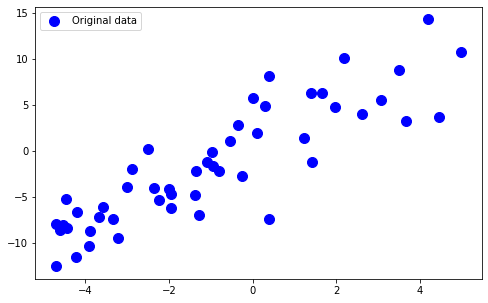

In [71]:
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, label='Original data', s=100, c='b')
plt.legend(loc="best")
plt.show()

In [72]:
import torch 

#### Converting data to pytorch tensors
By defualt requires_grad = False

In [73]:
X_train = torch.from_numpy(x_train).view(-1,1).float() 
Y_train = torch.from_numpy(y_train).view(-1,1).float()

print('requires_grad for X_train: ', X_train.requires_grad)
print('requires_grad for Y_train: ', Y_train.requires_grad)

requires_grad for X_train:  False
requires_grad for Y_train:  False


## Creating our model

We want to fit a line through our data points. Basically, for a 1D input (an *x*-value), we want to predict the parameter that 
maps the input to the line.

We can learn this parameter using PyTorch's ``Autograd``.


Setting requires_grad=True indicates that we want to compute gradients with respect to these Tensors during the backward pass

In [74]:
input_size = 1
output_size = 1

w = torch.rand(input_size, 
                output_size,                 
                requires_grad=True).float()
w.shape

torch.Size([1, 1])

## Training

We are now training a very simple linear regression model. Nevertheless, the training loop we use here is very similar (often even identical) to the
one we use whne training more complicated models, such as Convolutional Neural Networks.

The steps are usually the following:

#### Foward Pass:
* Predicting output from input data:    $ \hat{Y} = \mathcal{f}(X; \theta) $
* Computing forward pass as the product between $X$ and $w$ without any activation function

#### Finding Loss:
* Finding difference between $Y$ and $\hat{Y}$ through the Mean Squared Error 


#### Backward Pass:
* We let *Autograd* do the work. The *backward()* function computes the gradients of the loss with respect to all Tensors with requires_grad=True. 
* We can then just get the gradients by *w.grad*

#### Manually updating the weights
* weights have requires_grad=True, but we don't need to track this in autograd. So will wrap it in torch.no_grad
* reducing weight with multiple of learning rate and gradient
* manually zero the weight gradients after updating weights

In [75]:
learning_rate = 3e-4

In [76]:
# uncomment the following line to install tqdm if you havent done so
# !pip install tqdm

In [77]:
from tqdm import tqdm

In [78]:
N_ITERS = 1000
progress_bar = tqdm(range(N_ITERS), total=N_ITERS)
for i in progress_bar:
    
    # forward pass
    y_pred = torch.mm(X_train, w)
    
    # computing error
    loss = (y_pred - Y_train).pow(2).mean()

    # backprogating error to compute gradients
    loss.backward()
    # updating arameters
    with torch.no_grad():
        w -= learning_rate * w.grad
        w.grad.zero_()
    
    if(i % 50 == 0 or i == N_ITERS-1):
        progress_bar.set_description(f"Iter {i+1}: loss {loss.item():.5f}. ")

Iter 1000: loss 9.86194. : 100%|██████████| 1000/1000 [00:00<00:00, 9483.63it/s]


In [79]:
print ('w: ', w)

w:  tensor([[1.9820]], requires_grad=True)


#### Checking the output

Converting data into a tensor

In [80]:
x_train_tensor = torch.from_numpy(x_train).view(-1,1).float()
# x_train_tensor

#### Get the predicted values using the weights 
Using final weights calculated from our training in order to get the predicted values

In [81]:
predicted_in_tensor = x_train_tensor.mm(w)

predicted = predicted_in_tensor.detach().numpy()

#### Plotting
Our training has produced a rather accurate regression line

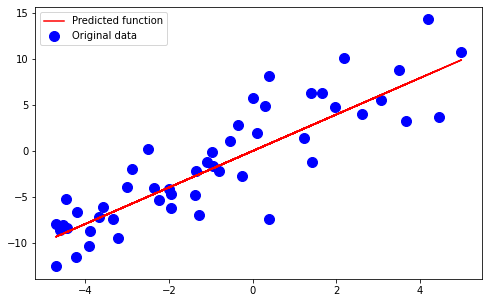

In [82]:
plt.figure(figsize=(8, 5))
plt.scatter(x_train, y_train, label = 'Original data', s=100, c='b') 
plt.plot(x_train, predicted, label='Predicted function', c="r")
plt.legend() 
plt.show()

## Using a Torch Optimizer

In the previous experiment, we have updated the the 'model' parameters manually by implementing the SGD equation ourselves.

Pytorch already includes several optimization functionaliities that we can use to make our lives easier.

In [83]:
set_random_seed(15)

We now create a somewhat more complicated dataset, but again asume that we know the underlying data distribution

$Y = \theta_1 x_1 + \theta_2 x_2 + \theta_3 + \mathcal{N}(0,\sigma^2)$ <br>
$Y = \mathbf{\theta}^T \mathbf{x} $  ; where $\mathbf{\theta} = [\theta_1, \theta_2, \theta_3]^T $ and $ \mathbf{x} = [x_1, x_2, 1]^T$

In [84]:
# dataset
N = 100
THETA = np.array([2, -1, 0.5])[:, np.newaxis]
SIGMA = 2

# input features
x_train = np.random.rand(N, 2) * 10 - 5
bias = np.ones((N,1))
x_train = np.concatenate((x_train, bias), axis=-1)

noise = np.random.randn(N,1) * SIGMA

# output features
y_train = np.matmul(x_train, THETA)  + noise

In [85]:
# np array to Torch Tensor
X_train = torch.from_numpy(x_train).float()
Y_train = torch.from_numpy(y_train).float()

In [86]:
# model: same as before. Only the size changes
input_size = 3
output_size = 1

w = torch.rand(input_size, 
               output_size,                 
               requires_grad=True).float()
w.shape

torch.Size([3, 1])

Note that the above $w$ is equivalent to a perceptron/fully connected layer with input size $3$, output size $1$ and no nonlinear activation function.

In [87]:
# optimizer and loss function
criterion = torch.nn.MSELoss()
# criterion = torch.nn.L1Loss()

learning_rate = 3e-4
optimizer = torch.optim.SGD(params=[w], lr=learning_rate)
# optimizer = torch.optim.SGD(params=[w], lr=learning_rate, momentum=0.9, nesterov=False)
# optimizer = torch.optim.Adam(params=[w], lr=learning_rate)

In [88]:
N_ITERS = 1000
progress_bar = tqdm(range(N_ITERS), total=N_ITERS)
for i in progress_bar:
    
    # forward pass
    y_pred = torch.mm(X_train, w)
    
    # computing error
    loss = criterion(y_pred, Y_train)

    # removing accumulated gradients
    optimizer.zero_grad()
    
    # backprogating error to compute gradients
    loss.backward()
    
    # updating arameters
    optimizer.step()
    
    if(i % 100 == 0 or i == N_ITERS-1):
        progress_bar.set_description(f"Iter {i+1}: loss {loss.item():.5f}. ")

Iter 1000: loss 3.57704. : 100%|██████████| 1000/1000 [00:00<00:00, 7567.19it/s]


In [89]:
print(f"Real parameters: {THETA[:,0]}")

Real parameters: [ 2.  -1.   0.5]


In [90]:
w_disp = [round(e.item(),3) for e in w[:,0].detach()]
print(f"Predicted parameters: {w_disp}")

Predicted parameters: [1.974, -0.969, 0.634]


# Logistic Regression

<img src="imgs/logreg1.jpg">

<img src="imgs/logreg2.jpg">

In [91]:
set_random_seed()

## Dataset

Let's now load a real dataset. We load data historical data on student admissions into a university.
For each 100 students, we have the applicant’s scores on two exams and the admissions decision.

Let's see how to build a PyTorch Logistic Regression classifier to predict whether a studnet will be admited or not 
given his exams results.

In [93]:
import csv
class Dataset:
    """
    Simple dataset with historical data on university admissions
    For 100 students we have:
       1- Score Exam 1
       2- Score Exam 2
       3- Acceptance/Rejection
    """
    def __init__(self):
        self.x_train, self.x_test = None, None
        self.y_train, self.y_test = None, None
        self._load_data()
        
    def _load_data(self):
        assert os.path.exists("data/exams.txt"), f"File containing data does not exist"
        with open("data/exams.txt") as f:
            reader = csv.reader(f)
            data = [r for r in reader]
        data = np.array(data, dtype="float64")
        np.random.shuffle(data)
        data = torch.from_numpy(data)
        
        # train/test split
        self.x_train = data[:70,:2].float() / 100  
        self.y_train = data[:70,-1].long()
        self.x_test = data[70:,:2].float() / 100  
        self.y_test = data[70:,-1].long()

dataset = Dataset()
x_train = dataset.x_train
y_train = dataset.y_train
x_test = dataset.x_test
y_test = dataset.y_test

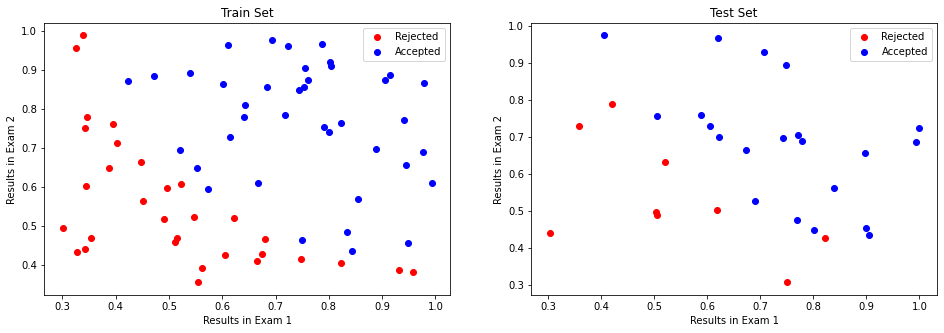

In [94]:
plt.figure(1, figsize=(16,5) )

plt.subplot(1,2,1)
idx = torch.where(y_train==0)[0]
plt.scatter(x_train[idx,0], x_train[idx,1], color='r', label="Rejected")
idx = torch.where(y_train==1)[0]
plt.scatter(x_train[idx,0], x_train[idx,1], color='b', label="Accepted")
plt.title("Train Set")
plt.xlabel("Results in Exam 1")
plt.ylabel("Results in Exam 2")
plt.legend(loc="best")


plt.subplot(1,2,2)
idx = torch.where(y_test==0)[0]
plt.scatter(x_test[idx,0], x_test[idx,1], color='r', label="Rejected")
idx = torch.where(y_test==1)[0]
plt.scatter(x_test[idx,0], x_test[idx,1], color='b', label="Accepted")
plt.title("Test Set")
plt.xlabel("Results in Exam 1")
plt.ylabel("Results in Exam 2")
plt.legend(loc="best")


plt.show()

## PyTorch Model

The model is again pretty much the same as in the linear regression example we saw before.
However, let's use this time the layers provided by PyTorch

When we implement a model in PyTorch, it must inherit from the ``nn.Module`` class. Furthermore, 
it must implement an ``__init__()`` and ``forward()`` method.

In [95]:
import torch.nn as nn

In [96]:
class Model(nn.Module):
    """
    Just one fully connected layer that takes two inputs and
    predicts a score for each of the two possible outcomes.
    """
    def __init__(self):
        """ Model initalizer """
        super().__init__()
        self.layer = torch.nn.Linear(2, 2)
        
    def forward(self, x):
        """ Forward pass through the model"""
        pred = self.layer(x)
        return pred

def count_model_params(model):
    """ Counting the number of learnable parameters in a nn.Module """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return num_params

In [97]:
model = Model()

In [98]:
n_params = count_model_params(model)
print(f"Model learnable parameters: {n_params} ")

Model learnable parameters: 6 


## Training

In [99]:
lr = 1e-2
criterion = torch.nn.CrossEntropyLoss()  # already includes a Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [100]:
N_ITERS = 10000
progress_bar = tqdm(range(N_ITERS), total=N_ITERS)
for i in progress_bar:
    
    # forward pass
    pred = model(x_train)
    
    # computing error
    loss = criterion(pred, y_train)

    # removing accumulated gradients
    optimizer.zero_grad()
    
    # backprogating error to compute gradients
    loss.backward()
    
    # updating arameters
    optimizer.step()
    
    if(i % 100 == 0 or i == N_ITERS-1):
        progress_bar.set_description(f"Iter {i+1}: loss {loss.item():.5f}. ")

Iter 10000: loss 0.21403. : 100%|██████████| 10000/10000 [00:02<00:00, 4245.40it/s]


## Evaluation

### Classification Accuracy

In [101]:
# forward pass
with torch.no_grad():
    scores = model(x_test)
    
pred = torch.argmax(scores, dim=-1)
n_correct = len(torch.where(pred == y_test)[0])
accuracy = n_correct / len(y_test) * 100
print(f"Classification accuracy: {round(accuracy, 2)}%")

Classification accuracy: 90.0%


### Decision Boundaries

The decision boundary corresponds to the points where the likelihood of each outcome is equals. In our example we have two outputs:
\begin{align}
    \mathbf{y_1} = \boldsymbol{\theta_1}^T \mathbf{x} = x_1 \theta_{1,1} + x_2 \theta_{1,2} + \theta_{1,3}\\
    \mathbf{y_2} = \boldsymbol{\theta_2}^T \mathbf{x} = x_1 \theta_{2,1} + x_2 \theta_{2,2} + \theta_{2,3} \\
\end{align}

At the decision boundary
\begin{align}
    \mathbf{y_1} = \mathbf{y_2} \text{.}
\end{align}
Hence, here
\begin{align}
    x_2 = \frac{(\theta_{2,1}-\theta_{1,1}) x_1 + (\theta_{2,3}- \theta_{1,3})}{\theta_{1,2} - \theta_{2,2}} \text{.}
\end{align}

In [102]:
weights = model.layer.weight.detach()
bias = model.layer.bias.detach()

In [103]:
print(weights)
print(bias)

tensor([[-8.4834, -8.8627],
        [ 8.3452,  8.1481]])
tensor([ 10.3217, -10.8607])


In [104]:
x = np.linspace(0.3, 1, 100)
y = ((weights[1,0] - weights[0,0]) * x + (bias[1] - bias[0])) / (weights[0,1] - weights[1,1]) 

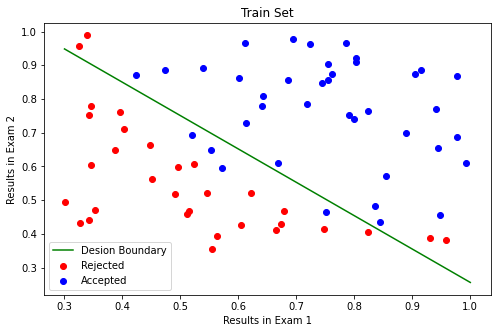

In [105]:
plt.figure(1, figsize=(8,5) )

idx = torch.where(y_train==0)[0]
plt.scatter(x_train[idx,0], x_train[idx,1], color='r', label="Rejected")
idx = torch.where(y_train==1)[0]
plt.scatter(x_train[idx,0], x_train[idx,1], color='b', label="Accepted")

plt.plot(x, y, label="Desion Boundary", color="g")

plt.title("Train Set")
plt.xlabel("Results in Exam 1")
plt.ylabel("Results in Exam 2")
plt.legend(loc="best")
plt.show()

### PyTorch MNIST Example

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Device is : cuda


In [107]:
# loading MNIST dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)
 

In [108]:
# making data loaders. We cannot (or at least should not) fir the 60000 images in memory
BATCH_SIZE = 256
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE, 
                                           shuffle=True)
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=False)

In [109]:
# defining model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=256, output_dim=10):
        super().__init__()
        self.input_dim = input_dim
        self.model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            )
    
    def forward(self, x):
        x_flat = x.view(-1, self.input_dim)
        out = self.model(x_flat)
        return out


In [110]:
# instanciating model
model = LogisticRegressionModel()
model = model.to(device)

n_params = count_model_params(model)
print(f"Model learnable parameters: {n_params} ")

Model learnable parameters: 203530 


In [111]:
# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)

lr = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [112]:
N_EPOCHS = 10
loss_hist  = []

for epoch in range(N_EPOCHS):
    loss_list = []
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for i, (imgs, labels) in progress_bar:
        
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred_labels = model(imgs)
    
        # computing error
        loss = criterion(pred_labels, labels)
        loss_list.append(loss.item())

        # removing accumulated gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if(i % 1 == 0 or i == N_ITERS-1):
            progress_bar.set_description(f"Epoch {epoch+1} Iter {i+1}: loss {loss.item():.5f}. ")
            
    loss_hist.append(np.mean(loss_list))

Epoch 10 Iter 235: loss 0.00652. : 100%|██████████| 235/235 [00:03<00:00, 63.54it/s]


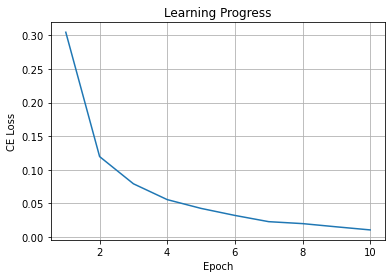

In [113]:
x = np.arange(1, len(loss_hist)+1)
plt.plot(x, loss_hist)
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("Learning Progress")
plt.show()

In [114]:
n_correct = 0

with torch.no_grad():
    progress_bar = tqdm(enumerate(test_loader), total=len(test_loader))
    for i, (imgs, labels) in progress_bar: 
        #everything needs to be on the same device
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        # forward pass
        pred_labels = model(imgs)
        
        preds = torch.argmax(pred_labels, dim=-1)
        cur_correct = len(torch.where(preds == labels)[0])
        n_correct = n_correct + cur_correct

accuracy = n_correct / len(test_dataset) * 100
print(f"Test accuracy: {round(accuracy,2)}%")

100%|██████████| 40/40 [00:00<00:00, 76.29it/s]

Test accuracy: 98.19%


## Saving and Loading Model Checkpoints

In [115]:
if(not os.path.exists("models")):
        os.makedirs("models")
savepath = f"models/checkpoint_epoch_{epoch}.pth"

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, savepath)

In [116]:
model = LogisticRegressionModel()
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

checkpoint = torch.load(savepath,  map_location="cpu")

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint["epoch"]

# CIFAR-10 Data

In [117]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 


trainset = dsets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
testset = dsets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [118]:
len(trainset)

50000

In [119]:
len(testset)

10000

In [120]:
trainset[1][0].size()

torch.Size([3, 32, 32])

In [121]:
trainset[1][1]

9

In [122]:
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [123]:
CLASSES[trainset[1][1]]

'truck'

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline
trainset[0][0].numpy().shape

(3, 32, 32)

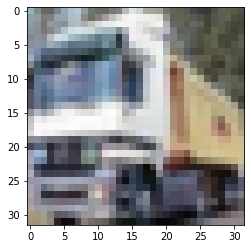

In [125]:
img = trainset[1][0]
img_disp = img.permute(1,2,0)

plt.imshow(img_disp)
plt.show()

# Assignment 2

- Train and Evaluate a Logistic Regression Classifier with CIFAR-10 dataset using PyTorch
- Draw learning curve and confusion matrix
- Try and compare different hyper-parameters (show me some nice plots :) )
- Plot gradient norm for some learnable parameters (e.g., last layer or so)
- Extra point:
    - Use some package (e.g., *hyperot* or *optuna*) to optimize two hyper-parameters (e.g, learning rate or batch size)

#### **Deadline: Sunday 23rd at 23:59**

## References:
 - https://pytorch.org/docs/stable/autograd.html#
 - https://pytorch.org/docs/stable/nn.html
 - http://cs231n.stanford.edu/


<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
    <b>Angel Villar-Corrales</b><br>
    <ul>
       <li> <b>Email</b>: villar@ais.uni-bonn.de
       <li> <b>Website</b>: angelvillarcorrales.com
    </ul>
</div> 